1. Seq_to_Seq LSTM Traffic Prediction

Train shape: (21708, 10, 6), Test shape: (5427, 10, 6)
Train targets shape: (21708, 6, 5), Test targets shape: (5427, 6, 5)
Train IDs shape: (21708,), Test IDs shape: (5427,)
Using device: cuda
Epoch 1/20 - Train Loss: 0.0169
Epoch 2/20 - Train Loss: 0.0099
Epoch 3/20 - Train Loss: 0.0093
Epoch 4/20 - Train Loss: 0.0085
Epoch 5/20 - Train Loss: 0.0080
Epoch 6/20 - Train Loss: 0.0078
Epoch 7/20 - Train Loss: 0.0072
Epoch 8/20 - Train Loss: 0.0070
Epoch 9/20 - Train Loss: 0.0069
Epoch 10/20 - Train Loss: 0.0069
Epoch 11/20 - Train Loss: 0.0067
Epoch 12/20 - Train Loss: 0.0068
Epoch 13/20 - Train Loss: 0.0067
Epoch 14/20 - Train Loss: 0.0068
Epoch 15/20 - Train Loss: 0.0068
Epoch 16/20 - Train Loss: 0.0066
Epoch 17/20 - Train Loss: 0.0068
Epoch 18/20 - Train Loss: 0.0065
Epoch 19/20 - Train Loss: 0.0066
Epoch 20/20 - Train Loss: 0.0065
Model saved as seq2seq_lstm_multistep_with_extraData.pth
Using device: cuda

Evaluation Metrics for All 5 Targets:

 rnti_count Evaluation:
  - MSE   : 0.0

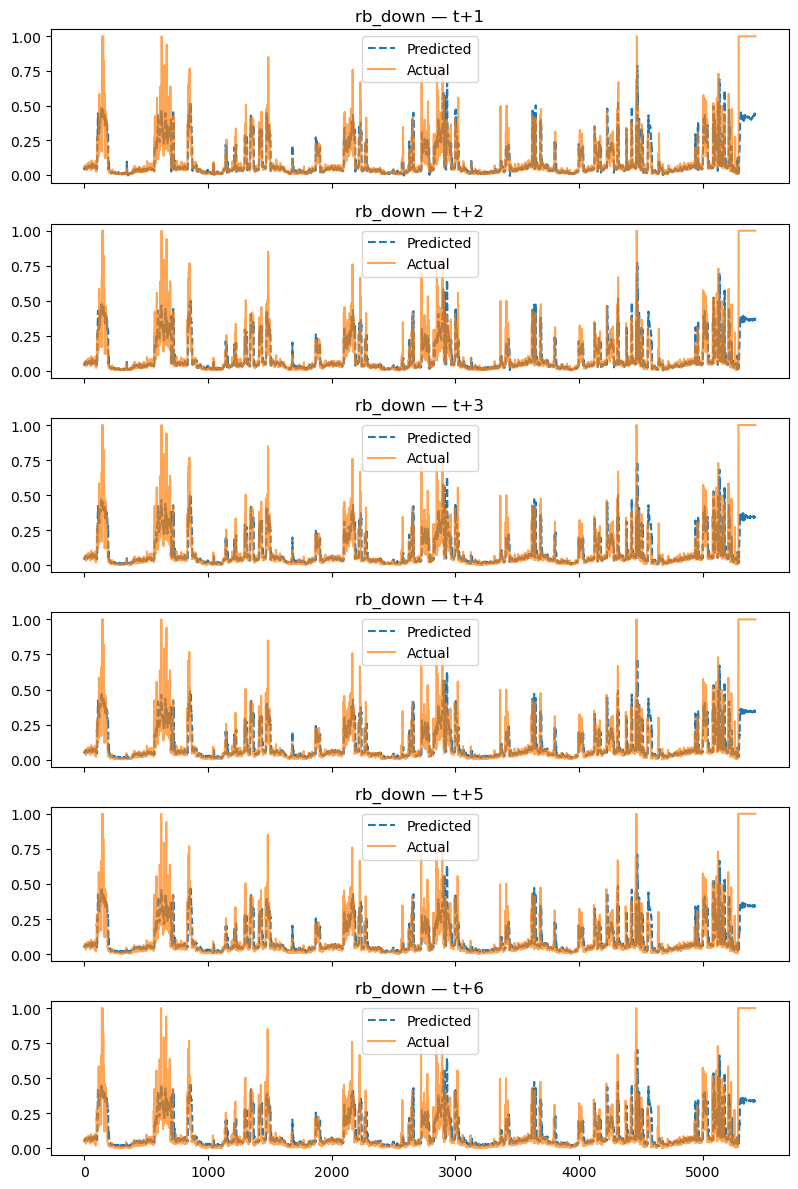

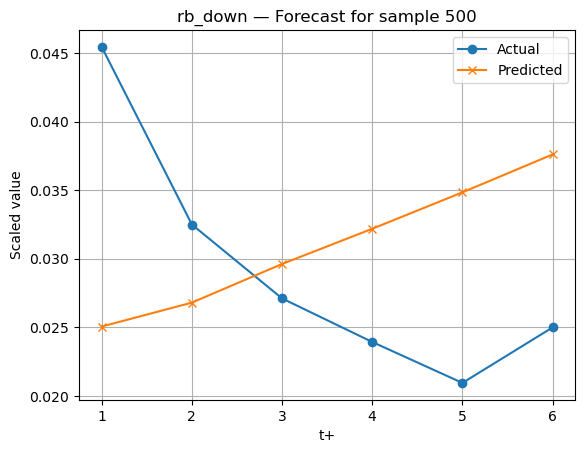


Forecast plots for down


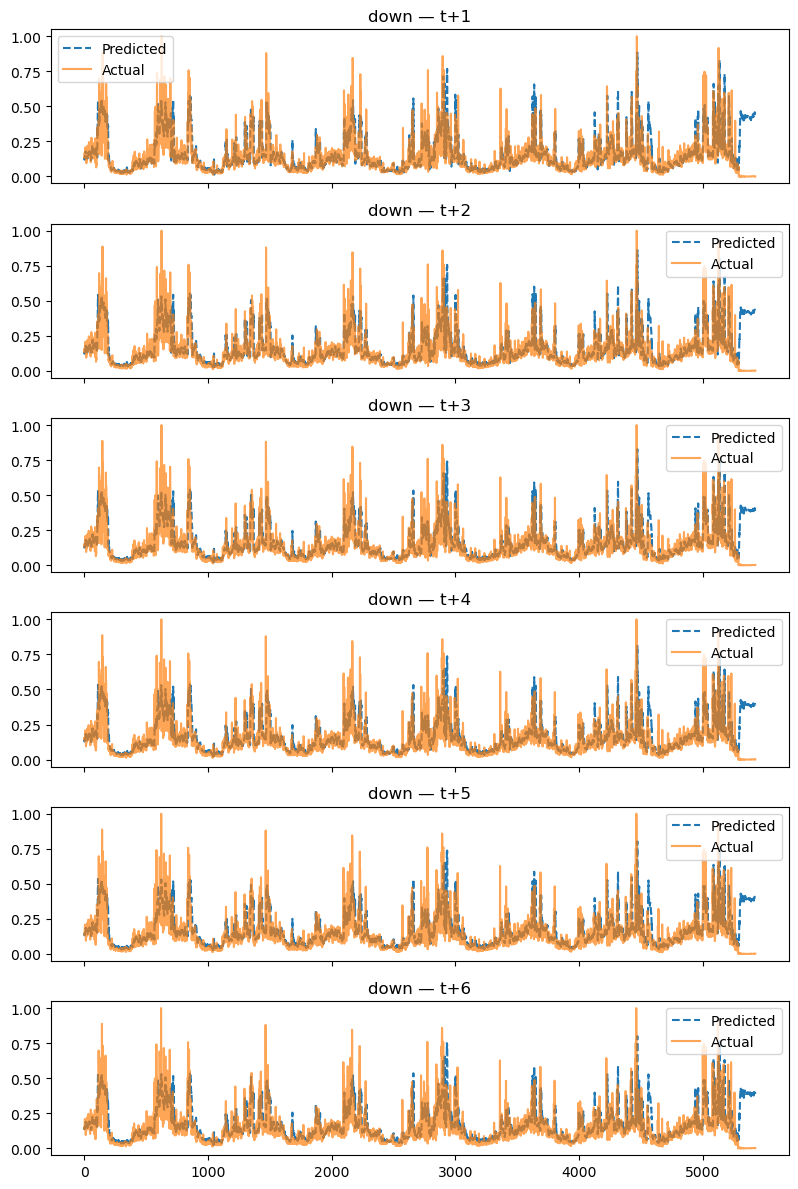

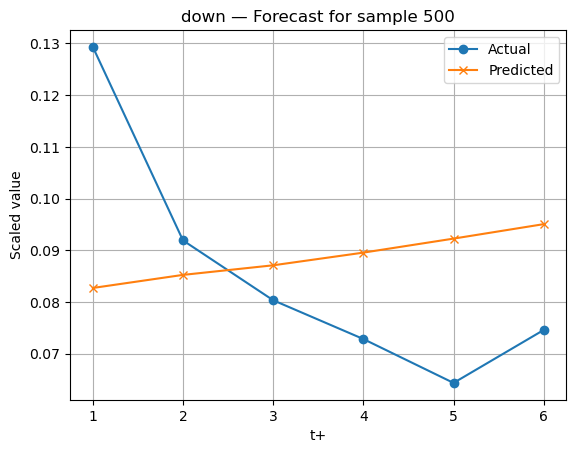

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader, TensorDataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

# getting process data from prepared dataset function earlier defined in data_utils file

X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")

# ─────────────────────────────────────────────────────────────
# STEP 1: Configurations
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',   
    batch_size=128,
    lr=0.001,
    epochs=20,
    cuda=True,
    seed=42
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 3: Load and prepare data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

# ─────────────────────────────────────────────────────────────
# STEP 4: Model initialization
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = Seq2SeqLSTM(input_size=input_dim,
                    hidden_size=64,
                    output_size=output_dim,
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# ─────────────────────────────────────────────────────────────
# STEP 5: Training Loop
for epoch in range(args.epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, teacher_forcing_ratio=0.5, decoder_targets=yb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {avg_loss:.4f}")

    # ─────────────────────────────────────────────────────────────
# STEP 6: Save model
torch.save(model.state_dict(), "seq2seq_lstm_multistep_with_extraData.pth")
print("Model saved as seq2seq_lstm_multistep_with_extraData.pth")

# ─────────────────────────────────────────────────────────────

                        #Evaluation

# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    batch_size=128,
    cuda=True,
    seed=42
)

device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_lstm_multistep_with_extraData.pth", map_location=device))
model.eval()

# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics MSE, RMSE, MAE, Rsquared, NRMSE
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)

2. Clustering

Combined shape: (27151, 13)


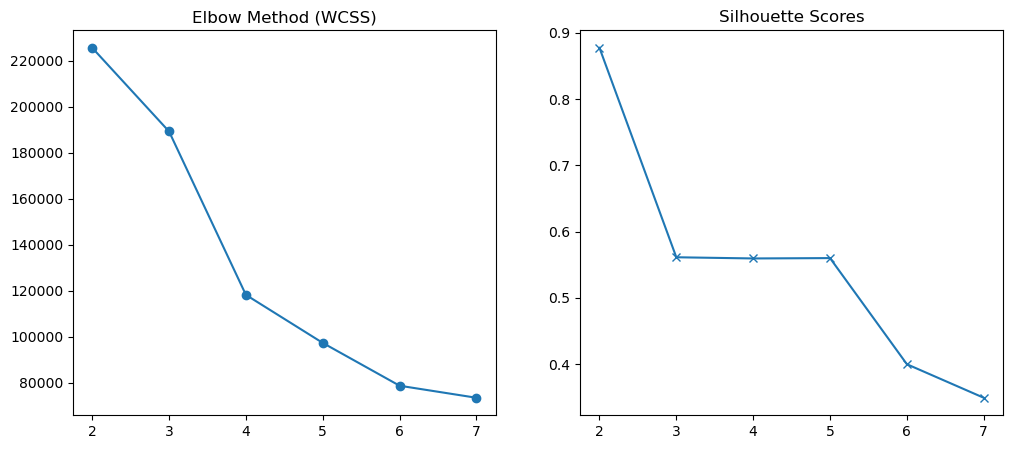


🔍 KMeans Clustering:
Silhouette Score: 0.5613491176286152
Calinski-Harabasz Index: 7842.491584084037

🔍 DBSCAN Clustering:
Silhouette Score: 0.7712645198422138
Calinski-Harabasz Index: 1548.305917562319

🔍 Hierarchical Clustering:
Silhouette Score: 0.5557451704608548
Calinski-Harabasz Index: 15091.856976233294


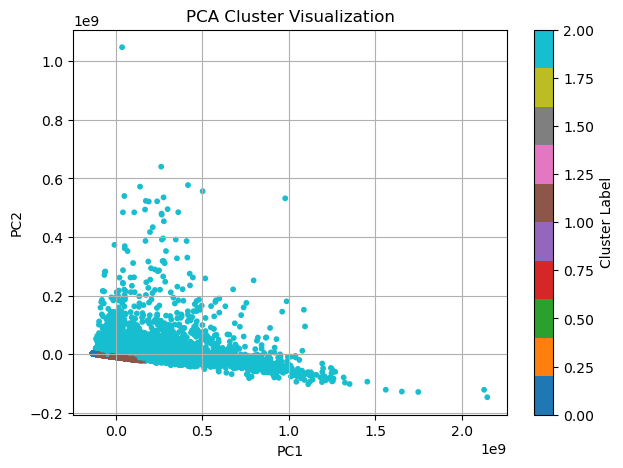

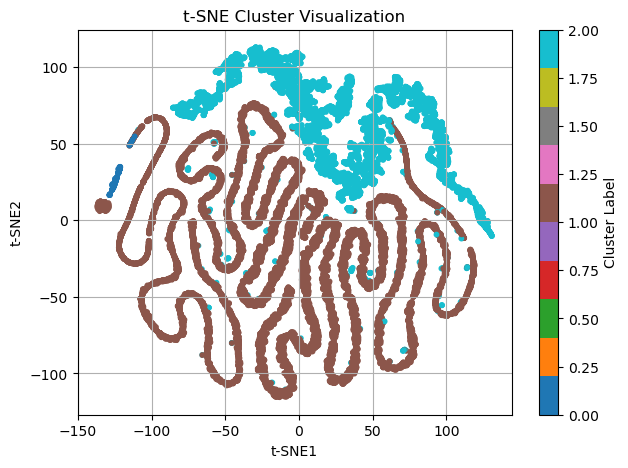

,time,down,up,rnti_count,mcs_down,mcs_down_var,mcs_up,mcs_up_var,rb_down,rb_down_var,rb_up,rb_up_var,District,Cluster_Feature
0,2018-03-28 15:56:00,174876888.0,1856888.0,10229.0,15.332298,87.157688,14.981497,49.989484,0.029681,4.497698e-08,0.000541,3.143297e-08,ElBorn,1
1,2018-03-28 15:58:00,209054184.0,2866200.0,12223.0,15.116846,87.192168,16.432612,62.494670,0.035971,4.615535e-08,0.000852,4.439640e-08,ElBorn,1
2,2018-03-28 16:00:00,191464640.0,1935360.0,11152.0,15.215739,87.227955,15.885238,63.087007,0.032750,4.646104e-08,0.000607,2.993595e-08,ElBorn,1
3,2018-03-28 16:02:00,241515688.0,2991152.0,14040.0,15.135400,86.199501,15.714660,77.187459,0.041372,4.532153e-08,0.000925,5.382563e-08,ElBorn,1
4,2018-03-28 16:04:00,264131088.0,3288816.0,15247.0,15.188944,86.151119,15.414080,69.118561,0.045074,4.655543e-08,0.001021,5.922178e-08,ElBorn,1


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

#Use the combined dataset for 

path = '../dataset/'

# Load and tag source
df_all = pd.read_csv(path+"full_dataset_with_extraData.csv")
print(f"Combined shape: {df_all.shape}")
df_all.head(2)

#--------------------------------------------------
# Data Preprocessing
#--------------------------------------------------
# Drop non-numeric + time column
features = df_all.drop(columns=["time", "District"])

# Fill NA values
features = features.fillna(features.mean())

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

#--------------------------------------------------
#Determine optimal number of clusters
#--------------------------------------------------

# Calculate WCSS (Within-Cluster Sum of Squares) and Silhouette Scores for different cluster counts
wcss = [] # List to store WCSS for each k
silhouette_scores = [] # List to store silhouette scores for each k

for k in range(2, 8):
    model = KMeans(n_clusters=k, random_state=42)
    preds = model.fit_predict(X_scaled)
    wcss.append(model.inertia_) # Inertia is the WCSS for current k
    silhouette_scores.append(silhouette_score(X_scaled, preds)) # How well clusters are separated

# Plot the Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))

# Elbow Method plot: helps to visually determine the optimal number of clusters (look for the "elbow")
plt.subplot(1, 2, 1)
plt.plot(range(2, 8), wcss, marker='o')
plt.title('Elbow Method (WCSS)')

# Silhouette Score plot: higher values mean better-defined clusters
plt.subplot(1, 2, 2)
plt.plot(range(2, 8), silhouette_scores, marker='x')
plt.title('Silhouette Scores')
plt.show()

#--------------------------------------------------
#Run different clustering algorithms
#--------------------------------------------------
# Define a dictionary of clustering models to compare
models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),        
    "DBSCAN": DBSCAN(eps=1.5, min_samples=5),
    "Hierarchical": AgglomerativeClustering(n_clusters=3)
}

# Fit each clustering model and store the resulting cluster labels in the dataframe
for name, model in models.items():
    labels = model.fit_predict(X_scaled)
    df_all[f"{name}_Cluster"] = labels

#--------------------------------------------------
# Evaluate clustering performance using Silhouette Score and Calinski-Harabasz Index
#--------------------------------------------------
# Calculate and print clustering metrics for each model
for name in models.keys():
    labels = df_all[f"{name}_Cluster"]
    if len(set(labels)) > 1:
        print(f"\n🔍 {name} Clustering:")
        print("Silhouette Score:", silhouette_score(X_scaled, labels))
        print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, labels))
    else:
        print(f"\n⚠️ {name} returned only 1 cluster — skipping metrics.")

#--------------------------------------------------
# Visualize clusters using PCA and t-SNE
#--------------------------------------------------

# Use the best cluster result
features = df_all.drop(columns=["time", "District", "KMeans_Cluster", "DBSCAN_Cluster"])  # Kept Hierarchical_Cluster

X = features.select_dtypes(include=[float, int]).fillna(0).values
labels = df_all["Hierarchical_Cluster"]

# PCA Visualization
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("PCA Cluster Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# t-SNE Visualization (slower)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("t-SNE Cluster Visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# ─────────────────────────────────────────────────────────────
#Add cluster as feature to the original dataset
#-────────────────────────────────────────────────────────────
# Convert cluster column to numeric type
df_all["Hierarchical_Cluster"] = df_all["Hierarchical_Cluster"].astype(int)

# Add to main features
df_all["Cluster_Feature"] = df_all["Hierarchical_Cluster"]

df_all = df_all.drop(columns=["KMeans_Cluster", "DBSCAN_Cluster", "Hierarchical_Cluster"])  # Keep only Hierarchical_Cluster

# Save and use in prepare_dataset
df_all.to_csv(path+"combined_with_cluster_feature_with_extraData.csv", index=False)

df_all.head(5)

3. Seq to seq with cluster feature

Epoch 1/50 - Train Loss: 2.8828
Epoch 2/50 - Train Loss: 2.3052
Epoch 3/50 - Train Loss: 2.1506
Epoch 4/50 - Train Loss: 1.8609
Epoch 5/50 - Train Loss: 1.7529
Epoch 6/50 - Train Loss: 1.6874
Epoch 7/50 - Train Loss: 1.6545
Epoch 8/50 - Train Loss: 1.6386
Epoch 9/50 - Train Loss: 1.6174
Epoch 10/50 - Train Loss: 1.6051
Epoch 11/50 - Train Loss: 1.5925
Epoch 12/50 - Train Loss: 1.5800
Epoch 13/50 - Train Loss: 1.5618
Epoch 14/50 - Train Loss: 1.5656
Epoch 15/50 - Train Loss: 1.5612
Epoch 16/50 - Train Loss: 1.5550
Epoch 17/50 - Train Loss: 1.5447
Epoch 18/50 - Train Loss: 1.5445
Epoch 19/50 - Train Loss: 1.5303
Epoch 20/50 - Train Loss: 1.5493
Epoch 21/50 - Train Loss: 1.5229
Epoch 22/50 - Train Loss: 1.5225
Epoch 23/50 - Train Loss: 1.5161
Epoch 24/50 - Train Loss: 1.5079
Epoch 25/50 - Train Loss: 1.5027
Epoch 26/50 - Train Loss: 1.4950
Epoch 27/50 - Train Loss: 1.4950
Epoch 28/50 - Train Loss: 1.5015
Epoch 29/50 - Train Loss: 1.4833
Epoch 30/50 - Train Loss: 1.4725
Epoch 31/50 - Train

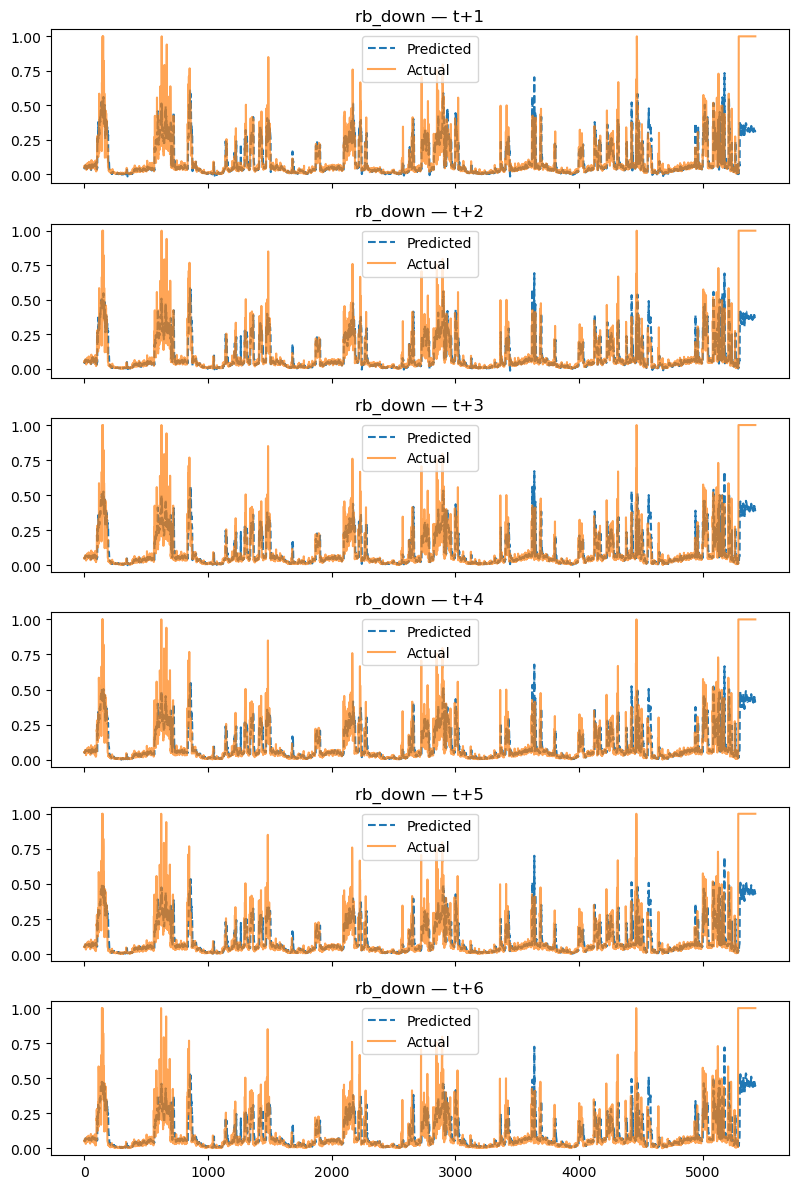

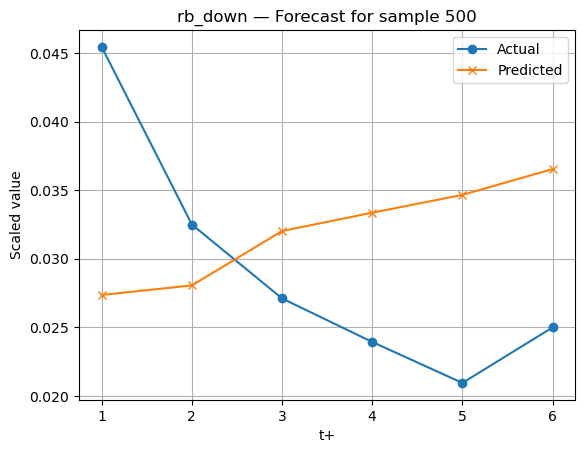


 Forecast plots for down


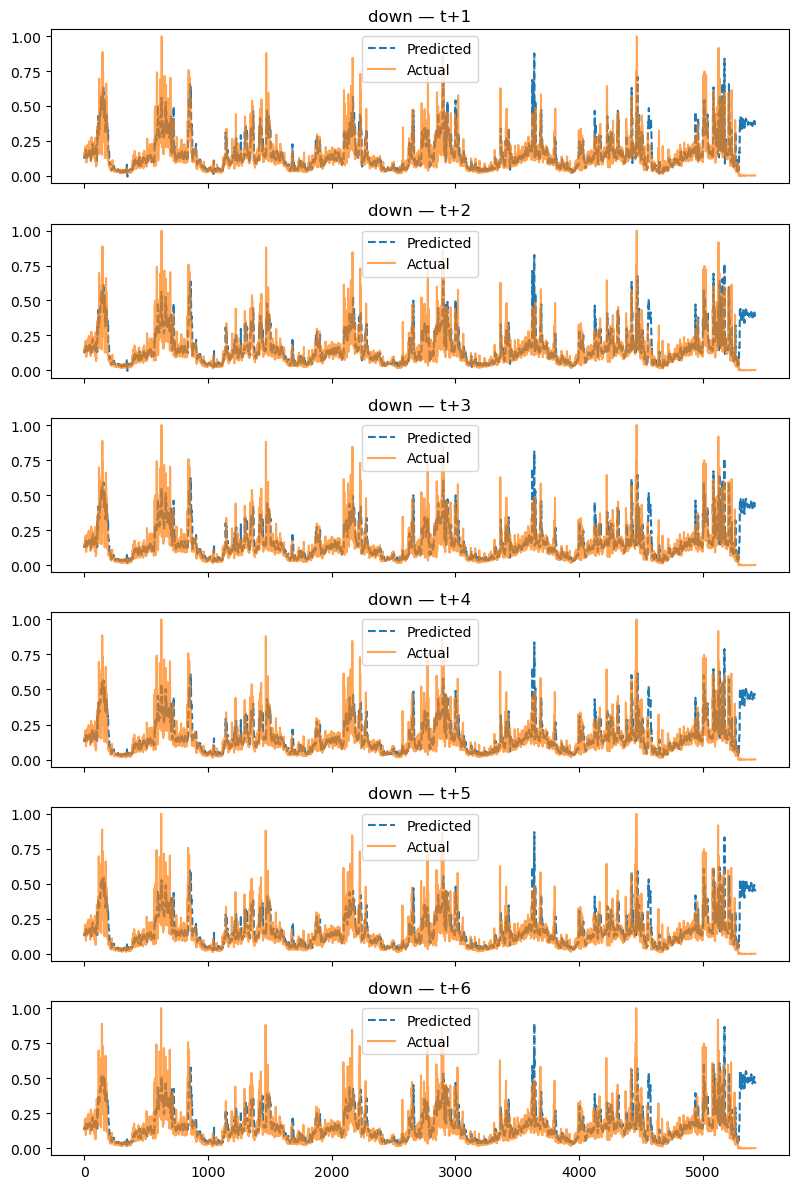

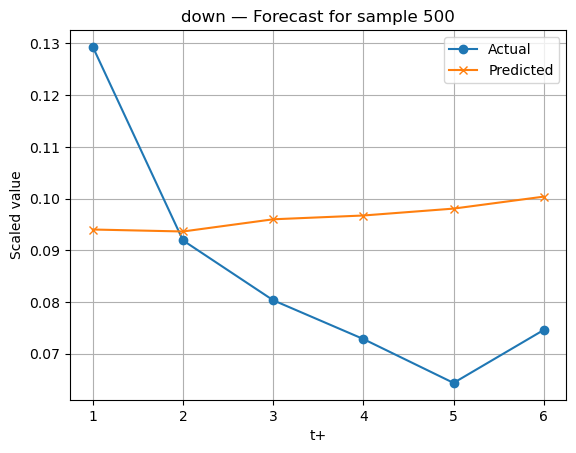

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from types import SimpleNamespace as Namespace
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ─────────────────────────────────────────────────────────────
# STEP 1: Define Config
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    use_time_features=False
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Load Data with Cluster Feature
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# ─────────────────────────────────────────────────────────────
# STEP 3: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# ─────────────────────────────────────────────────────────────
# STEP 4: Model Init & Training
input_dim = X_train.shape[-1]
output_dim = y_train.shape[-1]
forecast_steps = args.forecast_steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Seq2SeqLSTM(
    input_size=input_dim,
    hidden_size=64,
    output_size=output_dim,
    forecast_steps=forecast_steps
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.HuberLoss()  # More robust than MSE

# Training
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss:.4f}")

    # Save model
torch.save(model.state_dict(), "seq2seq_cluster_with_extra_data.pt")

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation
# -────────────────────────────────────────────────────────────

import torch
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace as Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ml.utils.data_utils import prepare_dataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM

# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    use_time_features=False
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_cluster_with_extra_data.pt", map_location=device))
model.eval()

# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\n Forecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)

Train shape: (21708, 10, 6), Test shape: (5427, 10, 6)
Train targets shape: (21708, 6, 5), Test targets shape: (5427, 6, 5)
Train IDs shape: (21708,), Test IDs shape: (5427,)
Using device: cuda
Epoch 1/20 - Train Loss: 0.0169
Epoch 2/20 - Train Loss: 0.0099
Epoch 3/20 - Train Loss: 0.0093
Epoch 4/20 - Train Loss: 0.0085
Epoch 5/20 - Train Loss: 0.0080
Epoch 6/20 - Train Loss: 0.0078
Epoch 7/20 - Train Loss: 0.0072
Epoch 8/20 - Train Loss: 0.0070
Epoch 9/20 - Train Loss: 0.0069
Epoch 10/20 - Train Loss: 0.0069
Epoch 11/20 - Train Loss: 0.0067
Epoch 12/20 - Train Loss: 0.0068
Epoch 13/20 - Train Loss: 0.0067
Epoch 14/20 - Train Loss: 0.0068
Epoch 15/20 - Train Loss: 0.0068
Epoch 16/20 - Train Loss: 0.0066
Epoch 17/20 - Train Loss: 0.0068
Epoch 18/20 - Train Loss: 0.0065
Epoch 19/20 - Train Loss: 0.0066
Epoch 20/20 - Train Loss: 0.0065
Model saved as seq2seq_lstm_multistep_with_extraData.pth
Using device: cuda

Evaluation Metrics for All 5 Targets:

 rnti_count Evaluation:
  - MSE   : 0.0

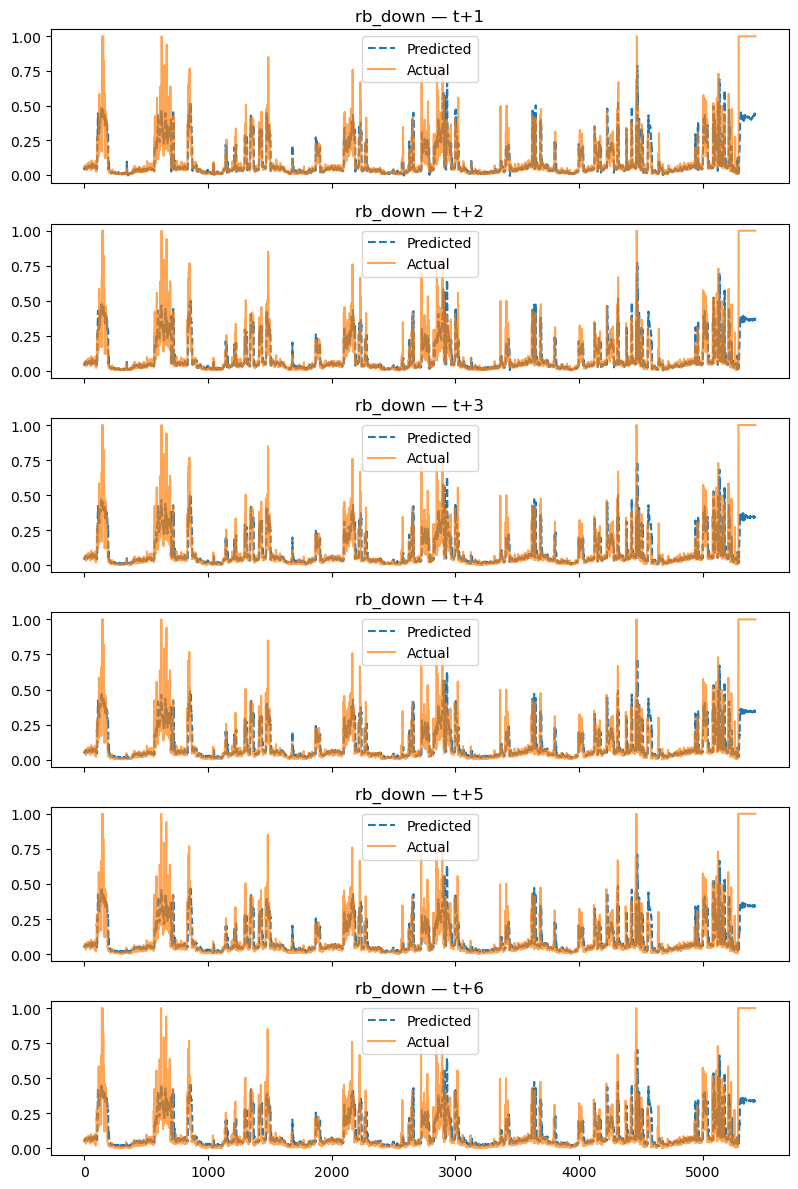

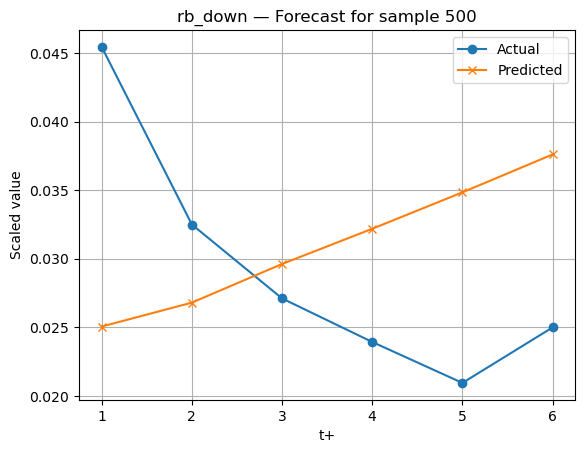


Forecast plots for down


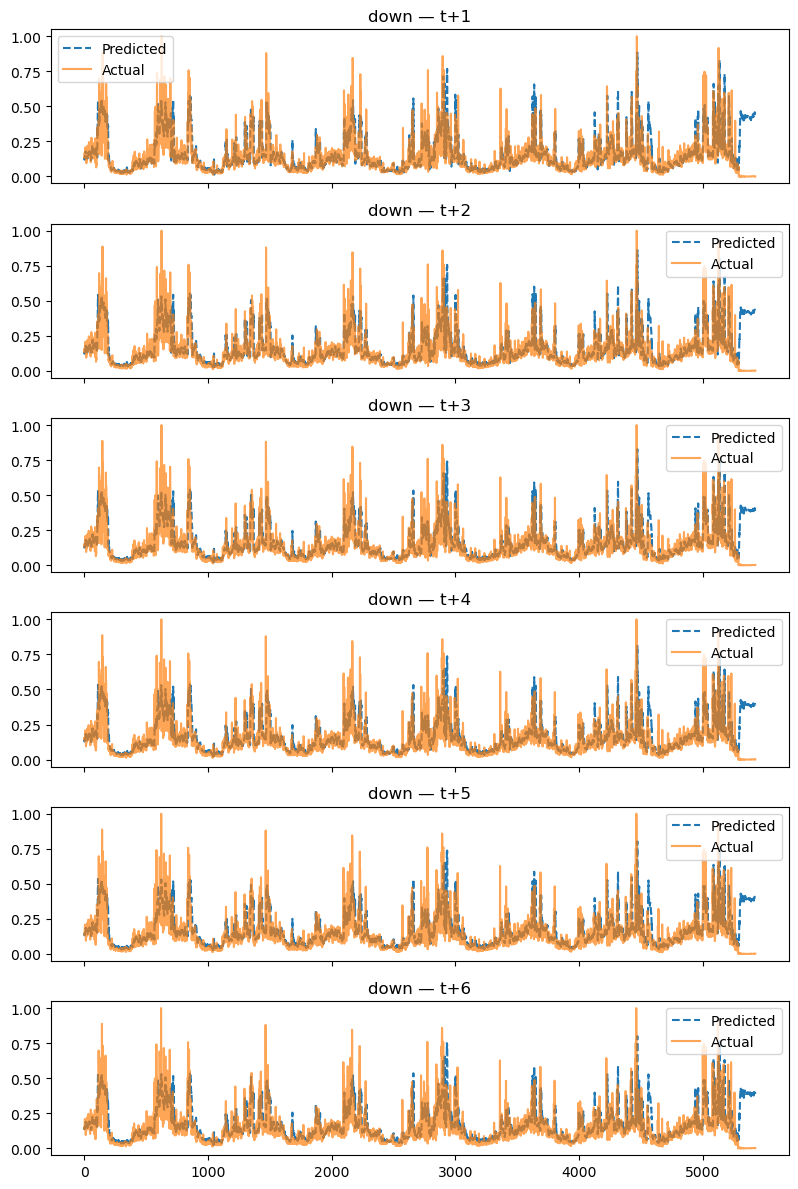

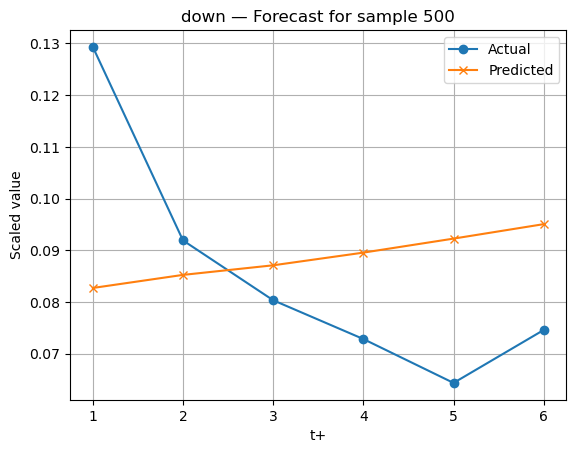

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader, TensorDataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

# getting process data from prepared dataset function earlier defined in data_utils file

X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")

# ─────────────────────────────────────────────────────────────
# STEP 1: Configurations
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',   
    batch_size=128,
    lr=0.001,
    epochs=20,
    cuda=True,
    seed=42
)

# ─────────────────────────────────────────────────────────────
# STEP 2: Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 3: Load and prepare data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

# ─────────────────────────────────────────────────────────────
# STEP 4: Model initialization
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = Seq2SeqLSTM(input_size=input_dim,
                    hidden_size=64,
                    output_size=output_dim,
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# ─────────────────────────────────────────────────────────────
# STEP 5: Training Loop
for epoch in range(args.epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, teacher_forcing_ratio=0.5, decoder_targets=yb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {avg_loss:.4f}")

    # ─────────────────────────────────────────────────────────────
# STEP 6: Save model
torch.save(model.state_dict(), "seq2seq_lstm_multistep_with_extraData.pth")
print("Model saved as seq2seq_lstm_multistep_with_extraData.pth")

# ─────────────────────────────────────────────────────────────

                        #Evaluation

# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    batch_size=128,
    cuda=True,
    seed=42
)

device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_lstm_multistep_with_extraData.pth", map_location=device))
model.eval()

# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics MSE, RMSE, MAE, Rsquared, NRMSE
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)

4. Transformer with cluster

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from ml.models.transformer import TimeSeriesTransformer
from ml.utils.data_utils import prepare_dataset 

# -----------------------
# Config (cluster dataset)
# -----------------------
args = Namespace(
    data_path='../dataset/combined_with_cluster_feature_with_extraData.csv',  # <— clustered data
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,                  # encoder length (L)
    forecast_steps=6,             # horizon (H)
    test_size=0.2,                # 80/20 split
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    use_time_features=False,      # (kept off to mirror your cluster runs)

    # Transformer model hyperparams (match your working eval config)
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,

    # Training
    epochs=30,                    # you can bump this (e.g., 50) if needed
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    grad_clip=1.0,
    early_stopping_patience=8,    # stop if val loss doesn't improve

    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='transformer_multistep_cluster_with_extra_data.pt',     # best checkpoint (weights)
    )

# -----------------------
# Load data
# -----------------------
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
# Shapes
# X_*: [N, L, D]
# y_*: [N, H, T]
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test : {X_test.shape},  y_test : {y_test.shape}")

input_size  = X_train.shape[2]  # D
output_size = y_train.shape[2]  # T
L = X_train.shape[1]
H = y_train.shape[1]
assert L == args.num_lags and H == args.forecast_steps, "Check num_lags/forecast_steps vs data."

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                  torch.tensor(y_train, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=True, drop_last=False
)
val_loader = DataLoader(  # using test as validation for training loop; can split train if you prefer
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=False, drop_last=False
)

# -----------------------
# Build model
# -----------------------
model = TimeSeriesTransformer(
    input_size=input_size,
    output_size=output_size,
    forecast_steps=args.forecast_steps,
    d_model=args.d_model,
    nhead=args.nhead,
    num_encoder_layers=args.num_encoder_layers,
    num_decoder_layers=args.num_decoder_layers,
    dim_feedforward=args.dim_feedforward,
    dropout=args.dropout,
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = nn.MSELoss()

# Optional scheduler (cosine annealing works well for Transformers)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, args.epochs))

# -----------------------
# Train / Val loops
# -----------------------
best_val = float('inf')
best_epoch = -1
no_improve = 0

scaler_amp = torch.cuda.amp.GradScaler(enabled=(args.device == 'cuda'))

for epoch in range(1, args.epochs + 1):
    # ---- Train ----
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(args.device == 'cuda')):
            preds = model(xb)            # [B, H, T], trained on SCALED space
            loss = criterion(preds, yb)

        scaler_amp.scale(loss).backward()
        if args.grad_clip and args.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
        scaler_amp.step(optimizer)
        scaler_amp.update()

        running += loss.item()

    train_loss = running / max(1, len(train_loader))

    # ---- Validate ----
    model.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb, yb in val_loader:
            xb, yb = xb.to(args.device), yb.to(args.device)
            preds = model(xb)
            vloss += criterion(preds, yb).item()
        val_loss = vloss / max(1, len(val_loader))

    if scheduler is not None:
        scheduler.step()

    print(f"[{epoch:03d}/{args.epochs}] Train {train_loss:.6f} | Val {val_loss:.6f} | LR {optimizer.param_groups[0]['lr']:.2e}")

    # ---- Early Stopping + Best Save ----
    if val_loss < best_val - 1e-8:
        best_val = val_loss
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), args.save_path)
    else:
        no_improve += 1
        if no_improve >= args.early_stopping_patience:
            print(f"Early stopping at epoch {epoch} (best={best_val:.6f} @ {best_epoch})")
            break

X_train: (21708, 10, 7), y_train: (21708, 6, 5)
X_test : (5427, 10, 7),  y_test : (5427, 6, 5)
[001/30] Train 0.093033 | Val 0.025922 | LR 9.97e-04
[002/30] Train 0.016452 | Val 0.024215 | LR 9.89e-04
[003/30] Train 0.013537 | Val 0.019133 | LR 9.76e-04
[004/30] Train 0.012408 | Val 0.021338 | LR 9.57e-04
[005/30] Train 0.011783 | Val 0.019347 | LR 9.33e-04
[006/30] Train 0.011063 | Val 0.017901 | LR 9.05e-04
[007/30] Train 0.010446 | Val 0.018706 | LR 8.72e-04
[008/30] Train 0.010354 | Val 0.018179 | LR 8.35e-04
[009/30] Train 0.010219 | Val 0.017540 | LR 7.94e-04
[010/30] Train 0.010144 | Val 0.016579 | LR 7.50e-04
[011/30] Train 0.009958 | Val 0.016748 | LR 7.03e-04
[012/30] Train 0.009782 | Val 0.016018 | LR 6.55e-04
[013/30] Train 0.009570 | Val 0.016253 | LR 6.04e-04
[014/30] Train 0.009605 | Val 0.016282 | LR 5.52e-04
[015/30] Train 0.009411 | Val 0.016336 | LR 5.00e-04
[016/30] Train 0.009432 | Val 0.016290 | LR 4.48e-04
[017/30] Train 0.009321 | Val 0.016346 | LR 3.96e-04
[018

5. Transformer without cluster

[1/20] Train Loss: 0.0737
[2/20] Train Loss: 0.0137
[3/20] Train Loss: 0.0119
[4/20] Train Loss: 0.0111
[5/20] Train Loss: 0.0106
[6/20] Train Loss: 0.0106
[7/20] Train Loss: 0.0102
[8/20] Train Loss: 0.0101
[9/20] Train Loss: 0.0100
[10/20] Train Loss: 0.0098
[11/20] Train Loss: 0.0098
[12/20] Train Loss: 0.0097
[13/20] Train Loss: 0.0096
[14/20] Train Loss: 0.0097
[15/20] Train Loss: 0.0097
[16/20] Train Loss: 0.0097
[17/20] Train Loss: 0.0094
[18/20] Train Loss: 0.0096
[19/20] Train Loss: 0.0095
[20/20] Train Loss: 0.0094
Saved Transformer model to: transformer_multistep_with_extraData.pt

Sanity check: value ranges per target (original scale)
rnti_count    y_true:[483, 1.44e+04]   y_pred:[-38.58, 1.57e+04]
rb_down       y_true:[0.001867, 0.3783]   y_pred:[-0.008314, 0.2321]
rb_up         y_true:[2.5e-07, 0.1192]   y_pred:[-0.001582, 0.0752]
down          y_true:[1.591e+06, 8.42e+08]   y_pred:[-3.674e+06, 6.341e+08]
up            y_true:[0, 1.228e+08]   y_pred:[-1.695e+06, 9.506e+07

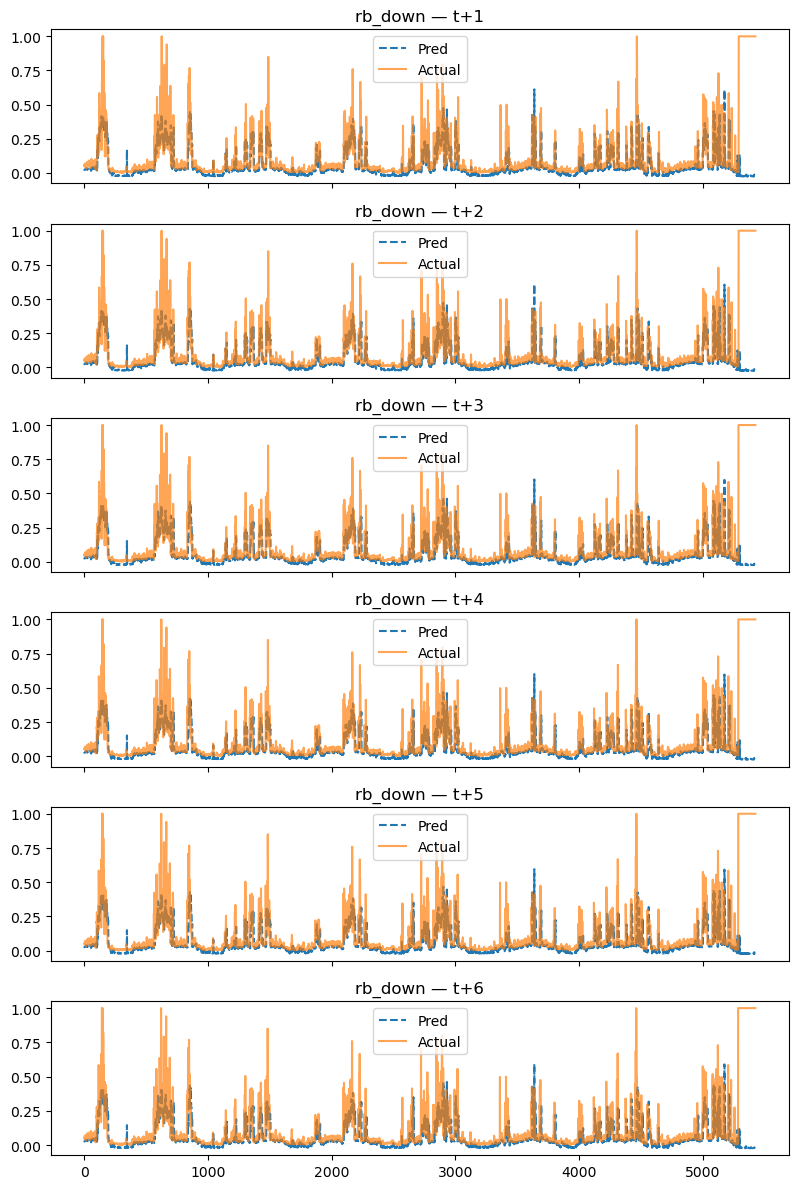

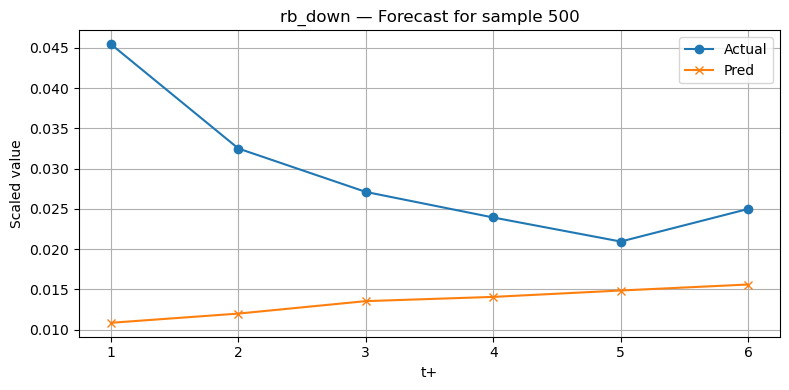


Forecast plots for down


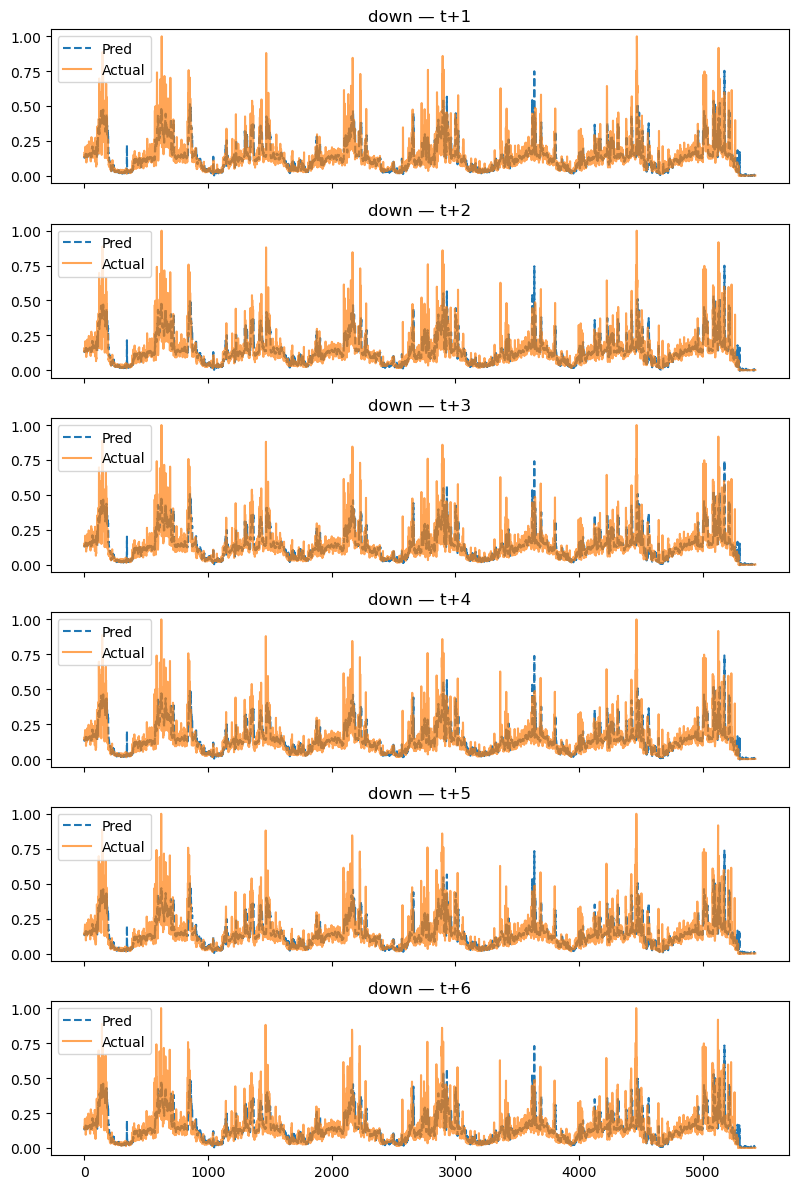

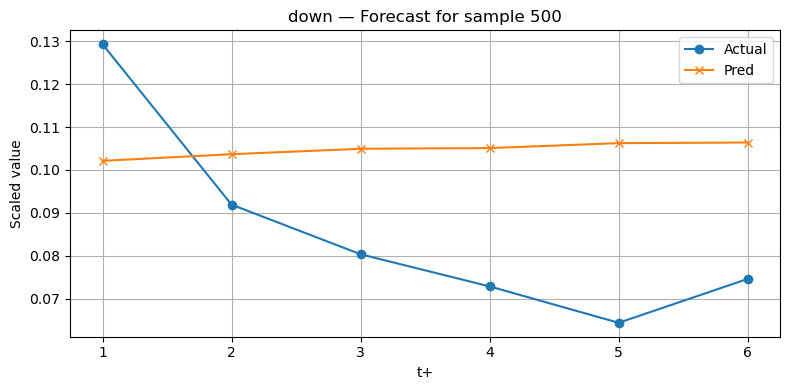

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from ml.models.transformer import TimeSeriesTransformer
from ml.utils.data_utils import prepare_dataset  

# -----------------------------
# 1) Config
# -----------------------------
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,                  # encoder length L
    forecast_steps=6,             # horizon H
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,

    # Model
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,

    # Train
    epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=0.0,
    grad_clip=1.0,

    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='transformer_multistep_with_extraData.pt'
)

# -----------------------------
# 2) Data
# -----------------------------
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
# X: [N, L, D], y: [N, 6, 5]
input_size  = X_train.shape[2]
output_size = y_train.shape[2]

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                  torch.tensor(y_train, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=args.batch_size, shuffle=False
)

# -----------------------------
# 3) Model
# -----------------------------
model = TimeSeriesTransformer(
    input_size=input_size,
    output_size=output_size,
    forecast_steps=args.forecast_steps,
    d_model=args.d_model,
    nhead=args.nhead,
    num_encoder_layers=args.num_encoder_layers,
    num_decoder_layers=args.num_decoder_layers,
    dim_feedforward=args.dim_feedforward,
    dropout=args.dropout,
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = nn.MSELoss()

# -----------------------------
# 4) Train
# -----------------------------
best_loss = float('inf')
for epoch in range(1, args.epochs + 1):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(args.device), yb.to(args.device)
        optimizer.zero_grad()
        preds = model(xb)                 # [B, 6, 5]
        loss = criterion(preds, yb)
        loss.backward()
        if args.grad_clip and args.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)
        optimizer.step()
        total += loss.item()
    print(f"[{epoch}/{args.epochs}] Train Loss: {total/len(train_loader):.4f}")

# -----------------------------
# 5) Save
# -----------------------------
torch.save(model.state_dict(), args.save_path)
print(f"Saved Transformer model to: {args.save_path}")

# -----------------------------
# 0) Config
# -----------------------------
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',

    # MUST match how you trained the transformer
    d_model=128,
    nhead=4,
    num_encoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
)

MODEL_PATH = "transformer_multistep_with_extraData.pt"

# -----------------------------
# 1) Load data & scalers
# -----------------------------
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
input_size  = X_test.shape[2]
output_size = y_test.shape[2]
seq_len     = args.num_lags
pred_len    = args.forecast_steps

test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=256, shuffle=False
)

# -----------------------------
# 2) Build and load model
# -----------------------------
model = TimeSeriesTransformer(
    input_size=input_size,
    d_model=args.d_model,
    nhead=args.nhead,
    num_encoder_layers=args.num_encoder_layers,
    dim_feedforward=args.dim_feedforward,
    dropout=args.dropout,
    output_size=output_size,
    forecast_steps=pred_len
).to(args.device)

state = torch.load(MODEL_PATH, map_location=args.device)
model.load_state_dict(state)
model.eval()

# -----------------------------
# 3) Predict
# -----------------------------
preds_list = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(args.device)
        preds_list.append(model(xb).cpu().numpy())  # [B, 6, 5]
preds = np.concatenate(preds_list, axis=0)  # [N, 6, 5]

# -----------------------------
# 4) Inverse transform (order safe)
# -----------------------------
def inverse_transform_order_safe(arr_3d, scaler, current_names):
    """
    arr_3d: [N, S, T] with columns in current_names order
    Align columns to scaler.feature_names_in_ (if present), inverse_transform,
    then map back to current_names order.
    """
    N, S, T = arr_3d.shape
    flat = arr_3d.reshape(-1, T)

    scaler_names = None
    if hasattr(scaler, "feature_names_in_"):
        scaler_names = list(scaler.feature_names_in_)

    if scaler_names and scaler_names != list(current_names):
        # Map flat -> scaler order
        idx_to_scaler = [current_names.index(name) for name in scaler_names]
        flat_reordered = flat[:, idx_to_scaler]
        inv = scaler.inverse_transform(flat_reordered)
        # Map back -> current_names order
        scaler_to_current = [scaler_names.index(name) for name in current_names]
        flat_back = inv[:, scaler_to_current]
    else:
        flat_back = scaler.inverse_transform(flat)

    return flat_back.reshape(N, S, T)

# Inverse-transform predictions & ground truth on ORIGINAL scale
y_true_inv  = inverse_transform_order_safe(y_test,  y_scaler, args.targets)
preds_inv   = inverse_transform_order_safe(preds,   y_scaler, args.targets)

# -----------------------------
# 5) Sanity check ranges
# -----------------------------
print("\nSanity check: value ranges per target (original scale)")
for i, var in enumerate(args.targets):
    yt_min, yt_max = np.min(y_true_inv[..., i]), np.max(y_true_inv[..., i])
    yp_min, yp_max = np.min(preds_inv[..., i]), np.max(preds_inv[..., i])
    print(f"{var:12s}  y_true:[{yt_min:.4g}, {yt_max:.4g}]   y_pred:[{yp_min:.4g}, {yp_max:.4g}]")


# -----------------------------
# 6) Metrics (robust MAPE + sMAPE)
# -----------------------------
NONNEG = set(['rnti_count','rb_down','rb_up','down','up'])
preds_eval = preds_inv.copy()
for i, name in enumerate(args.targets):
    if name in NONNEG:
        preds_eval[..., i] = np.clip(preds_eval[..., i], 0.0, None)

# 2) Metrics
def smape(y, p, eps=1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    denom = (np.abs(y) + np.abs(p)) / 2.0
    denom = np.clip(denom, eps, None)
    return np.mean(np.abs(y - p) / denom) * 100.0

def wape(y, p, eps=1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return 100.0 * np.sum(np.abs(y - p)) / (np.sum(np.abs(y)) + eps)

def mape_raw(y, p, eps=1e-8):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return 100.0 * np.mean(np.abs((y - p) / np.clip(np.abs(y), eps, None)))

def mape_masked(y, p, floor=None):
    """
    Exclude near-zero y from the denominator to avoid blow-ups.
    If floor is None, use 10% of the median(|y|), min 1e-6.
    """
    y = np.asarray(y, float); p = np.asarray(p, float)
    if floor is None:
        med = np.median(np.abs(y[y != 0])) if np.any(y != 0) else 0.0
        floor = max(1e-6, 0.10 * med)
    mask = np.abs(y) >= floor
    if mask.sum() == 0:
        return np.nan
    return 100.0 * np.mean(np.abs((y[mask] - p[mask]) / np.abs(y[mask])))

def rmsle(y, p):
    """Root Mean Squared Log Error (requires y,p >= 0)."""
    y = np.clip(np.asarray(y, float), 0, None)
    p = np.clip(np.asarray(p, float), 0, None)
    return np.sqrt(np.mean((np.log1p(p) - np.log1p(y))**2))

def core_metrics(y, p):
    mse  = mean_squared_error(y, p)
    rmse = np.sqrt(mean_squared_error(y, p))
    mae  = mean_absolute_error(y, p)
    r2   = r2_score(y, p)
    nrmse = rmse / (np.max(y) - np.min(y) + 1e-12)
    return mse, rmse, mae, r2, nrmse

# 3) Flatten across time steps (if you want step-agnostic summary)
y_flat = y_true_inv.reshape(-1, y_true_inv.shape[-1])
p_flat = preds_eval.reshape(-1, preds_eval.shape[-1])

rows = []
print("\nEvaluation on ORIGINAL scale (flattened across steps) — robust % metrics:")
for i, var in enumerate(args.targets):
    yt, yp = y_flat[:, i], p_flat[:, i]
    mse, rmse, mae, r2, nrmse = core_metrics(yt, yp)
    smape_v = smape(yt, yp)
    wape_v  = wape(yt, yp)
    rmsle_v = rmsle(yt, yp)         # tells you order-of-magnitude mismatch
    mape_r  = mape_raw(yt, yp)      # for reference only
    mape_m  = mape_masked(yt, yp)   # recommended if you must report MAPE-like

    print(f"{var}: "
          f"MSE={mse:.4g}, RMSE={rmse:.4g}, MAE={mae:.4g}, R2={r2:.4f}, "
          f"NRMSE={nrmse:.4f}, WAPE={wape_v:.2f}%, sMAPE={smape_v:.2f}%, "
          f"RMSLE={rmsle_v:.4f}, MAPE_raw={mape_r:.2f}%, MAPE_masked={mape_m:.2f}%")

    rows.append({
        "Target": var, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE": nrmse,
        "WAPE(%)": wape_v, "sMAPE(%)": smape_v, "RMSLE": rmsle_v,
        "MAPE_raw(%)": mape_r, "MAPE_masked(%)": mape_m
    })

df_eval_flat = pd.DataFrame(rows)

# 4) Optional: per-step breakdown (uses same robust metrics)
step_rows = []
for step in range(y_true_inv.shape[1]):
    for i, var in enumerate(args.targets):
        yt, yp = y_true_inv[:, step, i], preds_eval[:, step, i]
        mse, rmse, mae, r2, nrmse = core_metrics(yt, yp)
        smape_v = smape(yt, yp)
        wape_v  = wape(yt, yp)
        rmsle_v = rmsle(yt, yp)
        mape_r  = mape_raw(yt, yp)
        mape_m  = mape_masked(yt, yp)
        step_rows.append({
            "Step": step+1, "Target": var, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE": nrmse,
            "WAPE(%)": wape_v, "sMAPE(%)": smape_v, "RMSLE": rmsle_v,
            "MAPE_raw(%)": mape_r, "MAPE_masked(%)": mape_m
        })
df_eval_steps = pd.DataFrame(step_rows)
df_eval_steps

# ─────────────────────────────────────────────────────────────
# 7) Visualizations (same patterns you used before)
def plot_all_steps(preds, y_test, var_name):
    """Plot all 6 horizons as 6 subplots for one variable."""
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(args.forecast_steps):
        axs[t].plot(preds[:, t, idx], label='Pred', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    """Plot t+1..t+6 for a single sample for one variable."""
    idx = args.targets.index(var_name)
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, args.forecast_steps+1), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, args.forecast_steps+1), preds[sample_idx, :, idx], label="Pred", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+"); plt.ylabel("Scaled value")
    plt.xticks(range(1, args.forecast_steps+1))
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)

6. Comparision Of Models with Extra data

In [10]:
import pandas as pd
import numpy as np
import torch
from argparse import Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from ml.utils.data_utils import prepare_dataset
from ml.models.lstm import LSTM
from ml.models.multi_step_lstm import MultiStepLSTM
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.models.transformer import TimeSeriesTransformer

# -----------------------------
# 0) CONFIG
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TARGETS = ['rnti_count', 'rb_down', 'rb_up', 'down', 'up']
H = 6  # forecast_steps

# checkpoints
#CKPT_BASE_T1     = "base_lstm_t1.pt"
#CKPT_MULTI       = "multi_step_lstm.pt"
CKPT_S2S_MULTI   = "seq2seq_lstm_multistep_with_extraData.pth"
CKPT_S2S_CLU     = "seq2seq_cluster_with_extra_data.pt"              # Seq2Seq Clusters
CKPT_TRANS       = "transformer_multistep_with_extraData.pt"
CKPT_TRANS_CLU   = "transformer_multistep_cluster_with_extra_data.pt"      # Transformer Clusters


# -----------------------------
# 1) DATA (full dataset) for 4 models
# -----------------------------
args_full = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=TARGETS,
    num_lags=10,
    forecast_steps=H,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    batch_size=128,
    cuda=torch.cuda.is_available(),
    seed=42
)
X_train, y_train, X_test, y_test, x_scaler_full, y_scaler_full, *_ = prepare_dataset(args_full)
# t+1 ground-truth on SCALED space (for Strategy A)
y_test_t1_scaled_full = y_test[:, 0, :]  # [N, 5]
N, L, D = X_test.shape
T = y_test.shape[2]


# -----------------------------
# 2) DATA (cluster dataset) for clustered models
# -----------------------------
args_cluster = Namespace(
    data_path='../dataset/combined_with_cluster_feature_with_extraData.csv',
    targets=TARGETS,
    num_lags=10,
    forecast_steps=H,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    batch_size=128,
    cuda=torch.cuda.is_available(),
    seed=42,
    use_time_features=False
)
X_tr_c, y_tr_c, X_te_c, y_te_c, x_scaler_c, y_scaler_c, *_ = prepare_dataset(args_cluster)
# t+1 ground-truth on SCALED space (for Strategy A, cluster set)
y_te_c_t1_scaled = y_te_c[:, 0, :]
Nc, Lc, Dc = X_te_c.shape

# -----------------------------
# 3) HELPERS 
# -----------------------------

# Core metrics on SCALED space (expects 2D arrays)
def metrics_scaled_space(y_true_scaled_2d, y_pred_scaled_2d):
    mse  = mean_squared_error(y_true_scaled_2d, y_pred_scaled_2d)
    rmse = np.sqrt(mean_squared_error(y_true_scaled_2d, y_pred_scaled_2d))
    mae  = mean_absolute_error(y_true_scaled_2d, y_pred_scaled_2d)
    r2   = r2_score(y_true_scaled_2d, y_pred_scaled_2d)
    # NRMSE on the scaled range present in y_true
    nrmse = rmse / (np.max(y_true_scaled_2d) - np.min(y_true_scaled_2d) + 1e-8)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE": nrmse}

# Percent metrics on ORIGINAL space (single target column)
def mape(y_true, y_pred, eps=1e-8):
    denom = np.clip(np.abs(y_true), eps, None)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def smape(y_true, y_pred, eps=1e-8):
    denom = np.clip((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps, None)
    return float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)

def masked_mape(y_true, y_pred, mask_thresh=1e-6, eps=1e-8):
    mask = np.abs(y_true) >= mask_thresh
    if mask.sum() == 0:
        return float('nan')
    denom = np.clip(np.abs(y_true[mask]), eps, None)
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / denom)) * 100.0)

def clamp_nonneg(x):
    return np.maximum(x, 0.0)

def inverse_single_col(y_scaled_1d, scaler, j):
    """
    Inverse-transform one target column j using fitted MinMaxScaler 'scaler'.
    y_scaled_1d: shape [N,]
    """
    min_j   = np.asarray(scaler.min_)[j]
    scale_j = np.asarray(scaler.scale_)[j]
    return (y_scaled_1d - min_j) / scale_j

def percent_metrics_original_space_single(y_true_scaled_1d, y_pred_scaled_1d, scaler, j, clamp=True):
    """
    Inverse only target column j back to ORIGINAL scale and compute percent metrics there.
    """
    yt = inverse_single_col(np.asarray(y_true_scaled_1d), scaler, j)
    yp = inverse_single_col(np.asarray(y_pred_scaled_1d), scaler, j)
    if clamp:
        yp = clamp_nonneg(yp)
    return {
        "MAPE%":        mape(yt, yp),
        "sMAPE%":       smape(yt, yp),
        "MAPE_masked%": masked_mape(yt, yp, mask_thresh=1e-6),
    }


# -----------------------------
# 4) LOAD MODELS
# -----------------------------


# Seq2Seq Multistep LSTM (full dataset)
s2s_model = Seq2SeqLSTM(
    input_size=D, hidden_size=64, output_size=T, forecast_steps=H, num_layers=1
).to(DEVICE)
s2s_model.load_state_dict(torch.load(CKPT_S2S_MULTI, map_location=DEVICE), strict=True)
s2s_model.eval()

# Seq2Seq Multistep LSTM (cluster dataset)
s2s_cluster_model = Seq2SeqLSTM(
    input_size=Dc, hidden_size=64, output_size=T, forecast_steps=H, num_layers=1
).to(DEVICE)
s2s_cluster_model.load_state_dict(torch.load(CKPT_S2S_CLU, map_location=DEVICE), strict=True)
s2s_cluster_model.eval()

# Transformer (full dataset)
transformer_model = TimeSeriesTransformer(
    input_size=D, output_size=T, forecast_steps=H,
    d_model=128, nhead=4, num_encoder_layers=2, num_decoder_layers=2,
    dim_feedforward=256, dropout=0.1
).to(DEVICE)
transformer_model.load_state_dict(torch.load(CKPT_TRANS, map_location=DEVICE), strict=True)
transformer_model.eval()

# Transformer (cluster dataset)
transformer_cluster_model = TimeSeriesTransformer(
    input_size=Dc, output_size=T, forecast_steps=H,
    d_model=128, nhead=4, num_encoder_layers=2, num_decoder_layers=2,
    dim_feedforward=256, dropout=0.1
).to(DEVICE)
transformer_cluster_model.load_state_dict(torch.load(CKPT_TRANS_CLU, map_location=DEVICE), strict=True)
transformer_cluster_model.eval()


# -----------------------------
# 5) PREDICT t+1 (SCALED space)
# -----------------------------
with torch.no_grad():
    xb_full = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)     # [N, L, D]
    xb_clu  = torch.tensor(X_te_c, dtype=torch.float32, device=DEVICE)     # [Nc, Lc, Dc]

    # Seq2Seq multistep (full)
    s2s_all = s2s_model(xb_full, teacher_forcing_ratio=0.0)
    s2s_t1_scaled = s2s_all[:, 0, :]

    # Seq2Seq multistep (cluster dataset)
    s2s_clu_all = s2s_cluster_model(xb_clu, teacher_forcing_ratio=0.0)
    s2s_clu_t1_scaled = s2s_clu_all[:, 0, :]

    # Transformer (full)
    trans_all = transformer_model(xb_full)
    trans_t1_scaled = trans_all[:, 0, :]

    # Transformer (cluster dataset)  <-- NEW
    trans_clu_all = transformer_cluster_model(xb_clu)
    trans_clu_t1_scaled = trans_clu_all[:, 0, :]

# to numpy
s2s_t1_scaled       = s2s_t1_scaled.cpu().numpy()
s2s_clu_t1_scaled   = s2s_clu_t1_scaled.cpu().numpy()
trans_t1_scaled     = trans_t1_scaled.cpu().numpy()
trans_clu_t1_scaled = trans_clu_t1_scaled.cpu().numpy()

# -----------------------------
# 6) STRATEGY A: BUILD COMPARISON TABLE (t+1)
#    Core metrics on SCALED; percent metrics on ORIGINAL
# -----------------------------

rows = []

def add_rows_for_model(name, y_pred_scaled, y_true_scaled, scaler, targets):
    for i, var in enumerate(targets):
        yt_s = y_true_scaled[:, i]
        yp_s = y_pred_scaled[:, i]
        # core on scaled
        m_core = metrics_scaled_space(yt_s.reshape(-1, 1), yp_s.reshape(-1, 1))
        # percent on original (inverse-transform this column only)
        m_pct  = percent_metrics_original_space_single(yt_s, yp_s, scaler, j=i, clamp=True)
        rows.append({
            "Strategy": "A_t+1",
            "Model": name,
            "Target": var,
            "MSE": m_core["MSE"],
            "RMSE": m_core["RMSE"],
            "MAE": m_core["MAE"],
            "R2": m_core["R2"],
            "NRMSE": m_core["NRMSE"],
            "MAPE%": m_pct["MAPE%"],
            "sMAPE%": m_pct["sMAPE%"],
            "MAPE_masked%": m_pct["MAPE_masked%"],
        })

# Four "full" models use (X_test / y_test / y_scaler_full)
FULL_MODELS_A = [
    ("Seq2Seq Multistep LSTM (t+1)", s2s_t1_scaled, y_test_t1_scaled_full, y_scaler_full),
    ("Transformer model (t+1)",      trans_t1_scaled, y_test_t1_scaled_full, y_scaler_full),
]
for mdl_name, pred_s, ytrue_s, scaler in FULL_MODELS_A:
    add_rows_for_model(mdl_name, pred_s, ytrue_s, scaler, TARGETS)

# Cluster models use (X_te_c / y_te_c / y_scaler_c)
CLU_MODELS_A = [
    ("Seq2Seq Multistep LSTM with Clusters (t+1)", s2s_clu_t1_scaled,   y_te_c_t1_scaled, y_scaler_c),
    ("Transformer model with Clusters (t+1)",      trans_clu_t1_scaled, y_te_c_t1_scaled, y_scaler_c),  # <-- NEW
]
for mdl_name, pred_s, ytrue_s, scaler in CLU_MODELS_A:
    add_rows_for_model(mdl_name, pred_s, ytrue_s, scaler, TARGETS)

df_t1 = pd.DataFrame(rows, columns=[
    "Strategy","Model","Target","MSE","RMSE","MAE","R2","NRMSE","MAPE%","sMAPE%","MAPE_masked%"
])
print("\n=== Strategy A (t+1) ===")
display(df_t1.head(15))

# -----------------------------
# 7) STRATEGY B: multi-step (t+1..t+6)
# -----------------------------

def infer_target_positions_from_data(X_test, y_t1_scaled):
    """
    Heuristic: for each target (col in y_t1_scaled), find the input feature
    column in X (last time step) with the highest absolute correlation.
    """
    assert X_test.ndim == 3 and y_t1_scaled.ndim == 2
    N, L, D = X_test.shape
    T = y_t1_scaled.shape[1]
    X_last = X_test[:, -1, :]
    pos, used = [], set()
    for i in range(T):
        yt = y_t1_scaled[:, i]
        yt = yt - yt.mean()
        yt_std = yt.std() + 1e-12
        corrs = []
        for j in range(D):
            xj = X_last[:, j]
            xj = xj - xj.mean()
            xj_std = xj.std() + 1e-12
            corr = float(np.mean((xj / xj_std) * (yt / yt_std)))
            corrs.append(abs(corr))
        for j in np.argsort(corrs)[::-1]:
            if j not in used:
                pos.append(int(j)); used.add(int(j)); break
    return pos

def validate_positions(pos_list, D, T):
    ok = (len(pos_list) == T and all(0 <= p < D for p in pos_list) and len(set(pos_list)) == T)
    if ok: return pos_list, True
    if T <= D:
        fallback = list(range(T))
        print(f"[WARN] Invalid TARGET_POS_IN_X={pos_list} for D={D}. "
              f"Falling back to {fallback}. Verify this mapping!")
        return fallback, False
    raise ValueError(f"Cannot fallback: T={T} > D={D}.")

# map targets to feature positions in X for FULL dataset (for base roll)
inferred = infer_target_positions_from_data(X_test, y_test_t1_scaled_full)
TARGET_POS_IN_X, _ = validate_positions(inferred, D=X_test.shape[2], T=y_test.shape[2])
print("Using TARGET_POS_IN_X =", TARGET_POS_IN_X)

def roll_base_lstm_to_horizon(base_model, X_init, steps, target_pos_in_x, device="cpu"):
    base_model.eval()
    x_win = torch.tensor(X_init, dtype=torch.float32, device=device)  # [N, L, D]
    outs = []
    with torch.no_grad():
        for _ in range(steps):
            y_next = base_model(x_win, device=device)  # [N, T] scaled
            outs.append(y_next.unsqueeze(1))
            last_row = x_win[:, -1, :].clone()
            for k, pos in enumerate(target_pos_in_x):
                last_row[:, pos] = y_next[:, k]
            x_win = torch.cat([x_win[:, 1:, :], last_row.unsqueeze(1)], dim=1)
    return torch.cat(outs, dim=1).detach().cpu().numpy()  # [N, steps, T]

# ----- FULL DATASET: multistep models
with torch.no_grad():
    xb_full = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)
    s2s_scaled         = s2s_model(xb_full, teacher_forcing_ratio=0.0).detach().cpu().numpy()
    trans_scaled       = transformer_model(xb_full).detach().cpu().numpy()
y_true_full_scaled = y_test

FULL_MODELS_STEPS = [
    ("Seq2Seq Multistep LSTM",       s2s_scaled,         y_true_full_scaled, y_scaler_full),
    ("Transformer model",            trans_scaled,       y_true_full_scaled, y_scaler_full),
]

# ----- CLUSTER DATASET: clustered models
with torch.no_grad():
    xb_clu = torch.tensor(X_te_c, dtype=torch.float32, device=DEVICE)
    s2s_clu_scaled   = s2s_cluster_model(xb_clu, teacher_forcing_ratio=0.0).detach().cpu().numpy()
    trans_clu_scaled = transformer_cluster_model(xb_clu).detach().cpu().numpy()  # <-- NEW
y_true_clu_scaled = y_te_c

CLU_MODELS_STEPS = [
    ("Seq2Seq Multistep LSTM with Clusters", s2s_clu_scaled,   y_true_clu_scaled, y_scaler_c),
    ("Transformer model with Clusters",      trans_clu_scaled, y_true_clu_scaled, y_scaler_c),  # <-- NEW
]

def evaluate_multistep_models(models_steps, targets, strategy_tag="B"):
    rows_steps, rows_over = [], []
    for name, y_pred_s, y_true_s, scaler in models_steps:
        if isinstance(y_pred_s, torch.Tensor): y_pred_s = y_pred_s.cpu().numpy()
        if isinstance(y_true_s, torch.Tensor): y_true_s = y_true_s.cpu().numpy()
        # per-step
        for step in range(H):
            for j, var in enumerate(targets):
                yt = y_true_s[:, step, j]
                yp = y_pred_s[:, step, j]
                m_core = metrics_scaled_space(yt.reshape(-1,1), yp.reshape(-1,1))
                m_pct  = percent_metrics_original_space_single(yt, yp, scaler, j=j, clamp=True)
                rows_steps.append({
                    "Strategy": f"{strategy_tag}_t+{step+1}",
                    "Step": step+1,
                    "Model": name,
                    "Target": var,
                    "MSE": m_core["MSE"],
                    "RMSE": m_core["RMSE"],
                    "MAE": m_core["MAE"],
                    "R2": m_core["R2"],
                    "NRMSE": m_core["NRMSE"],
                    "MAPE%": m_pct["MAPE%"],
                    "sMAPE%": m_pct["sMAPE%"],
                    "MAPE_masked%": m_pct["MAPE_masked%"],
                })
        # overall flattened
        for j, var in enumerate(targets):
            yt_all = y_true_s[:, :, j].reshape(-1)
            yp_all = y_pred_s[:, :, j].reshape(-1)
            m_core_all = metrics_scaled_space(yt_all.reshape(-1,1), yp_all.reshape(-1,1))
            m_pct_all  = percent_metrics_original_space_single(yt_all, yp_all, scaler, j=j, clamp=True)
            rows_over.append({
                "Strategy": f"{strategy_tag}_overall",
                "Model": name,
                "Target": var,
                "MSE": m_core_all["MSE"],
                "RMSE": m_core_all["RMSE"],
                "MAE": m_core_all["MAE"],
                "R2": m_core_all["R2"],
                "NRMSE": m_core_all["NRMSE"],
                "MAPE%": m_pct_all["MAPE%"],
                "sMAPE%": m_pct_all["sMAPE%"],
                "MAPE_masked%": m_pct_all["MAPE_masked%"],
            })
    df_steps = pd.DataFrame(rows_steps, columns=[
        "Strategy","Step","Model","Target",
        "MSE","RMSE","MAE","R2","NRMSE","MAPE%","sMAPE%","MAPE_masked%"
    ])
    df_over  = pd.DataFrame(rows_over, columns=[
        "Strategy","Model","Target",
        "MSE","RMSE","MAE","R2","NRMSE","MAPE%","sMAPE%","MAPE_masked%"
    ])
    return df_steps, df_over

# Evaluate FULL & CLUSTER
df_B_steps_full, df_B_overall_full = evaluate_multistep_models(
    FULL_MODELS_STEPS, targets=TARGETS, strategy_tag="B(FULL)"
)
df_B_steps_cluster, df_B_overall_cluster = evaluate_multistep_models(
    CLU_MODELS_STEPS, targets=TARGETS, strategy_tag="B(CLUSTER)"
)

df_B_steps_full

df_B_steps_cluster

df_B_overall_cluster

pd.concat([df_B_steps_full, df_B_steps_cluster]).to_excel("StrategyB_compare_rolled_over_steps_with_extraData.xlsx", index=False)
pd.concat([df_B_overall_full, df_B_overall_cluster]).to_excel("StrategyB_compare_rolled_over_overall_with_extraData.xlsx", index=False)
df_t1.to_excel("strategyA_compare_t1_with_extraData.xlsx", index=False)


=== Strategy A (t+1) ===


,Strategy,Model,Target,MSE,RMSE,MAE,R2,NRMSE,MAPE%,sMAPE%,MAPE_masked%
0,A_t+1,Seq2Seq Multistep LSTM (t+1),rnti_count,0.007641,0.087411,0.065128,0.511105,0.122158,2.800699e+01,24.221452,28.006990
1,A_t+1,Seq2Seq Multistep LSTM (t+1),rb_down,0.008360,0.091436,0.043395,0.557490,0.091583,4.038253e+01,35.048813,40.382529
2,A_t+1,Seq2Seq Multistep LSTM (t+1),rb_up,0.011933,0.109237,0.042965,0.617615,0.109237,6.285899e+02,98.639442,523.389137
3,A_t+1,Seq2Seq Multistep LSTM (t+1),down,0.008939,0.094547,0.057500,0.367591,0.094899,4.782040e+01,35.075285,47.820396
4,A_t+1,Seq2Seq Multistep LSTM (t+1),up,0.011148,0.105583,0.042664,0.538377,0.105583,8.686860e+11,73.609676,310.773656
5,A_t+1,Transformer model (t+1),rnti_count,0.006534,0.080833,0.060560,0.581915,0.112965,2.585516e+01,23.765878,25.855165
6,A_t+1,Transformer model (t+1),rb_down,0.010140,0.100697,0.058953,0.463309,0.100860,6.489222e+01,98.438968,64.892224
7,A_t+1,Transformer model (t+1),rb_up,0.014647,0.121024,0.048008,0.530647,0.121024,2.230961e+02,114.256215,223.278738
8,A_t+1,Transformer model (t+1),down,0.007127,0.084424,0.050489,0.495765,0.084738,3.935359e+01,32.199262,39.353589
9,A_t+1,Transformer model (t+1),up,0.011093,0.105324,0.043345,0.540644,0.105324,1.607257e+02,116.590148,160.904473


Using TARGET_POS_IN_X = [0, 1, 2, 3, 4]
